In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from PIL import Image
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

## Transforms object of Inception v3 model

In [2]:
weight = models.Inception_V3_Weights.IMAGENET1K_V1

transforms = weight.transforms()
transforms

ImageClassification(
    crop_size=[299]
    resize_size=[342]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

## Load the dataset

In [3]:
# Train Loader
train_dataset = CIFAR10('./data', train=True, transform=transforms, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Test Loader
test_dataset = CIFAR10('./data', train=False, transform=transforms, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:02<00:00, 77.1MB/s]


In [ ]:
train_loader.batch_size

64

In [ ]:
train_loader.dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
img, label = next(iter(train_loader))
print(img.shape)
print(label.shape)

torch.Size([64, 3, 299, 299])
torch.Size([64])


## Load the pretrained model

In [4]:
inception_model = models.inception_v3(weights=weight)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 143MB/s] 


In [ ]:
inception_model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
## Last fully connected layers
fc = inception_model.fc
fc

Linear(in_features=2048, out_features=10, bias=True)

## Frozen all layer

In [5]:
for (name, param) in inception_model.named_parameters():
  param.requires_grad = False

In [ ]:
# Print all the layer
for (name, param) in inception_model.named_parameters():
  print(name, param.requires_grad)

Conv2d_1a_3x3.conv.weight True
Conv2d_1a_3x3.bn.weight True
Conv2d_1a_3x3.bn.bias True
Conv2d_2a_3x3.conv.weight True
Conv2d_2a_3x3.bn.weight True
Conv2d_2a_3x3.bn.bias True
Conv2d_2b_3x3.conv.weight True
Conv2d_2b_3x3.bn.weight True
Conv2d_2b_3x3.bn.bias True
Conv2d_3b_1x1.conv.weight True
Conv2d_3b_1x1.bn.weight True
Conv2d_3b_1x1.bn.bias True
Conv2d_4a_3x3.conv.weight True
Conv2d_4a_3x3.bn.weight True
Conv2d_4a_3x3.bn.bias True
Mixed_5b.branch1x1.conv.weight True
Mixed_5b.branch1x1.bn.weight True
Mixed_5b.branch1x1.bn.bias True
Mixed_5b.branch5x5_1.conv.weight True
Mixed_5b.branch5x5_1.bn.weight True
Mixed_5b.branch5x5_1.bn.bias True
Mixed_5b.branch5x5_2.conv.weight True
Mixed_5b.branch5x5_2.bn.weight True
Mixed_5b.branch5x5_2.bn.bias True
Mixed_5b.branch3x3dbl_1.conv.weight True
Mixed_5b.branch3x3dbl_1.bn.weight True
Mixed_5b.branch3x3dbl_1.bn.bias True
Mixed_5b.branch3x3dbl_2.conv.weight True
Mixed_5b.branch3x3dbl_2.bn.weight True
Mixed_5b.branch3x3dbl_2.bn.bias True
Mixed_5b.bran

### Modify the classification layer

In [6]:
out_features = 10

# handle auxiliary layer
ax_fc = inception_model.AuxLogits.fc
in_axfeatures = ax_fc.in_features
inception_model.AuxLogits.fc = nn.Linear(in_axfeatures, 10)

# handle last fc layer
fc = inception_model.fc
in_features = fc.in_features
inception_model.fc = nn.Linear(in_features, out_features)

## Loss function and optimizer

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(inception_model.parameters(), lr=0.01)
inception_model = inception_model.to(device)

## Training loop

In [ ]:
epochs = 5

for epoch in range(epochs):
  running_loss = 0.0
  inception_model.train()

  for images, targets in train_loader:
    images, targets = images.to(device), targets.to(device)

    optimizer.zero_grad()
    outputs, aux_outputs = inception_model(images)
    loss1 = criterion(outputs, targets)
    loss2 = criterion(aux_outputs, targets)
    loss = loss1 + 0.4 * loss2
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  t_loss = running_loss / len(train_loader)
  print(f'Epoch {epoch + 1}/{epochs}, loss: {t_loss}')

path = f'/content/drive/MyDrive/Computer_vision/model/inception-v3-pytorch-e{epochs}.pth'
torch.save({
    'epochs': epochs,
    'classes': train_loader.dataset.classes,
    'model_state_dict': inception_model.state_dict()
}, path)
print('\nModel saved successfully.')

Epoch 1/5, loss: 4.183702513842326
Epoch 2/5, loss: 3.316574425800987
Epoch 3/5, loss: 3.313306763958748
Epoch 4/5, loss: 3.3037882890847636
Epoch 5/5, loss: 3.344719324422919

Model saved successfully.


## Load the model

In [8]:
model_path = '/content/drive/MyDrive/Computer_vision/model/inception-v3-pytorch-e5.pth'
checkpoint = torch.load(model_path, map_location=device)

classes = checkpoint['classes']
state_dict = checkpoint['model_state_dict']
inception_model.load_state_dict(state_dict)
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Model evalution

In [9]:
inception_model.eval()
correct, total = 0, 0

for images, labels in test_loader:
  images, labels = images.to(device), labels.to(device)

  with torch.no_grad():
    outputs = inception_model(images)
  pred = torch.argmax(outputs, dim=1)
  correct += (pred==labels).sum().item()
  total += labels.size(0)
acc = 100 * correct / total
print(f'Validation accuracy: {acc}')

Validation accuracy: 57.41


## Model inferencing

In [10]:
def preprocess_image(image_path, transforms):
  img = Image.open(image_path).convert('RGB')
  img = transforms(img).unsqueeze(0)

  return img

In [29]:
def predict(img, model):
  model.eval()
  with torch.no_grad():
    outputs = model(img)
  probalities = nn.functional.softmax(outputs[0], dim=0)
  (values, ids) = torch.topk(probalities, 5)

  return values, ids

In [23]:
import matplotlib.pyplot as plt

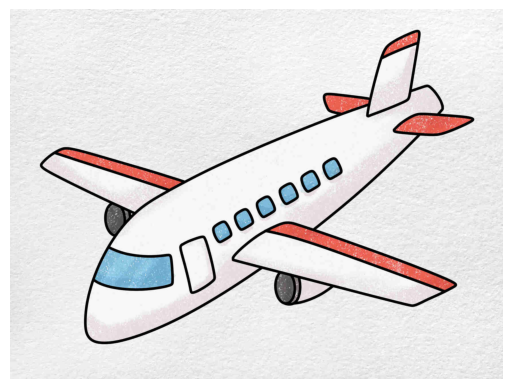

frog: 1.00
cat: 0.00
dog: 0.00
ship: 0.00
airplane: 0.00


In [30]:
image_path = '/content/draw-an-airplane.jpg'
img = preprocess_image(image_path, transforms)

values, ids = predict(img, inception_model)

img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

for value, id in zip(values, ids):
  print(f'{classes[id]}: {value:.2f}')